
Mass =  2.100 Earth masses
Radius =  1.22843 Earth radii
Density =  6.243 g/cc
Core Mass Fraction =  32.85
Core Radius Fraction =  51.71
CMB Pressure =  285.05 GPa
CMB Temperature =  3187.37 K
Central core pressure 0.84 TPa
Central core Temperature 4611.38 K



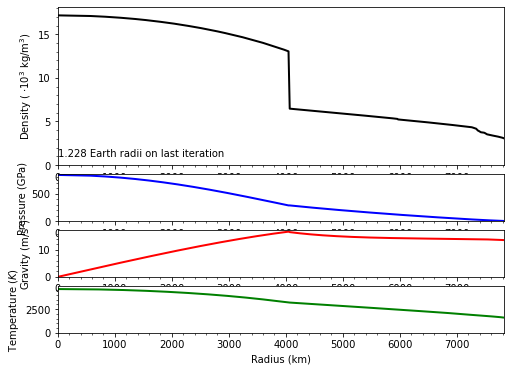

In [1]:

# This file is part of ExoPlex - a self consistent planet builder
# Copyright (C) 2017 - by the ExoPlex team, released under the GNU
# GPL v2 or later.

import os
import sys

# hack to allow scripts to be placed in subdirectories next to exoplex:
import numpy as np

if not os.path.exists('ExoPlex') and os.path.exists('../ExoPlex'):
    sys.path.insert(1, os.path.abspath('..'))
Pressure_range_mantle_UM = '1 1400000'
Temperature_range_mantle_UM = '1600 3500'

Pressure_range_mantle_LM = '1250000 40000000'
Temperature_range_mantle_LM = '1700 7000'

water_potential_temp = 300.

comp_keys = ['wt_frac_water','FeMg','SiMg','CaMg','AlMg','wt_frac_FeO_wanted','wt_frac_Si_core',
                          'wt_frac_O_core','wt_frac_S_core', 'combine_phases','use_grids','conserve_oxy']
struct_keys = ['Pressure_range_mantle_UM','Temperature_range_mantle_UM','resolution_UM',
                         'Pressure_range_mantle_LM', 'Temperature_range_mantle_LM', 'resolution_LM',
                         'Mantle_potential_temp','water_potential_temp']
combine_phases = True #note this is automatically done when use_grids = False and cannot be changed
use_grids = True

import ExoPlex as exo

if __name__ == "__main__":
    #To have ExoPlex to give you compositional info and status of calculation set Verbose to TRUE.
    #Note: setting this to True will slightly slow down the program
    verbose = False

    Mass_planet = 2.1  # in Earth masses
    #create filename to store values
    

    CaMg = 0.0697
    SiMg = 0.9016
    AlMg = 0.0756
    FeMg = 0.8958

    Output_filename = 'Filename'
    #Next user must input the ratios by mole (Earth is Ca/Mg = .07, Si.Mg = 0.90, Al/Mg = 0.09, Fe/Mg = 0.9)

    #How much water do you want in your planet? By mass fraction.
    wt_frac_water = 0.0

    #Don't forget that if you have water you need to add water layers
    number_h2o_layers = 0

    #The potential Temperature of Water, if present
    water_potential_temp = 300.

    #What fraction of the mantle would you like to be made of FeO? This Fe will be pulled from the core.
    wt_frac_FeO_wanted = 0. #by mass
    conserve_oxy = False

    #Now we can mix various elements into the core or mantle
    wt_frac_Si_core = 0. #by mass <1, note if you conserve oxygen this is calculated for you
    wt_frac_O_core = 0. #by mass
    wt_frac_S_core = 0. #by mass

    #What potential temperature (in K) do you want to start your mantle adiabat?
    Mantle_potential_temp = 1600.

    #Input the resolution of your upper mantle and lower mantle composition, density grids
    #These are input as number of T, P points. 50 50 = 2500 grid points, which takes about
    #5 minutes to calculate. Lower mantle resolution does not need to be higher since it's
    #mostly ppv.
    resolution_UM = '25 75'
    resolution_LM = '75 75'

    #lastly we need to decide how many layers to put in the planet. This is the resolution of
    #the mass-radius sampling.
    num_mantle_layers = 300
    num_core_layers = 300

    Output_radii = []
    Output_mass = []


    ######### Initalize and run ExoPlex



    compositional_params = dict(zip(comp_keys,[wt_frac_water,FeMg,SiMg,CaMg,AlMg,wt_frac_FeO_wanted,wt_frac_Si_core, \
                          wt_frac_O_core,wt_frac_S_core, combine_phases,use_grids,conserve_oxy]))

    if use_grids == True:
        filename = exo.functions.find_filename(compositional_params,verbose)
    else:
        filename=''

    structure_params = dict(zip(struct_keys, [Pressure_range_mantle_UM,Temperature_range_mantle_UM,resolution_UM,
                         Pressure_range_mantle_LM, Temperature_range_mantle_LM, resolution_LM,
                                              Mantle_potential_temp,water_potential_temp]))


    layers = [num_mantle_layers,num_core_layers,number_h2o_layers]

    #This is where we actually run the planet. First PerPlex grids of mineralogy, density,
    #Cp and alpha are calculated and stored in the Solutions folder. If the file already exists
    #(in name, not necessarily in composition), then PerPlex is not run again.
    Planet = exo.run_planet_mass(Mass_planet, compositional_params, structure_params, layers, filename, verbose)

    #check to see if solution works (P goes up with depth etc.)
    exo.functions.check(Planet)

    #Planet is a dictionary containing many parameters of interest:
    #Planet.get('radius') = list of the radial points from calculation (m)
    #Planet.get('mass') = list of the cumulative mass at each radius point from calculation (kg)
    #Planet.get('density') = list of densities from calculation (kg/m^3)
    #Planet.get('temperature') = list of temperature points from calculation (K)
    #Planet.get('gravity') = list of gravity points from calculation (SI)
    #Planet.get('pressure') = list of pressure points from calculation (bar)
    #Planet.get('phases') = list of phases and their molar fractions
    #Planet.get('alpha') = list of values of thermal expansivity points from calculation (1/K)
    #Planet.get('cp') = list of values of specific heat points from calculation (SI)

    print()
    print("Mass = ", '%.3f'%(Planet['mass'][-1]/5.97e24), "Earth masses")
    print("Radius = ", '%.5f'%(Planet['radius'][-1]/6371e3), "Earth radii")
    print("Density = ",'%.3f'%(Planet['mass'][-1]/(4/3 * np.pi *pow(Planet['radius'][-1],3))/1000), "g/cc")
    print("Core Mass Fraction = ", '%.2f'%(100.*Planet['mass'][num_core_layers-1]/Planet['mass'][-1]))
    print("Core Radius Fraction = ", '%.2f'%(100.*Planet['radius'][num_core_layers-1]/Planet['radius'][-1]))
    print("CMB Pressure = " ,'%.2f' % (Planet['pressure'][num_core_layers]/1e4), "GPa")
    print("CMB Temperature = " ,'%.2f' % (Planet['temperature'][num_core_layers]), "K")
    if number_h2o_layers >0:
        print("WMB Pressure = ", '%.2f' % (Planet['pressure'][num_core_layers+num_mantle_layers] // 1e4), "GPa")
        print("WMB Temperature = ", '%.2f' % (Planet['temperature'][num_core_layers+num_mantle_layers]), "K")

        print("number of oceans:",'%.2f' % (wt_frac_water*Planet['mass'][-1]/1.4e21))
    print("Central core pressure",'%.2f' % (Planet['pressure'][0]/1e7),"TPa")
    print("Central core Temperature",'%.2f' % (Planet['temperature'][0]),"K")
    print()
    #If you'd like the full output, uncomment out these lines!
    #Output_filename = Output_filename + '_Radius_'+ str('%.2f'%(Planet['radius'][-1]/6371e3))
    #exo.functions.write(Planet,Output_filename)

    #Now let us plot
    import matplotlib.pyplot as plt

    figure = plt.figure(figsize=(8, 6))

    ax1 = plt.subplot2grid((6, 3), (0, 0), colspan=3, rowspan=3)
    ax2 = plt.subplot2grid((6, 3), (3, 0), colspan=3, rowspan=1)
    ax3 = plt.subplot2grid((6, 3), (4, 0), colspan=3, rowspan=1)
    ax4 = plt.subplot2grid((6, 3), (5, 0), colspan=3, rowspan=1)

    ax1.plot(Planet['radius'] / 1.e3, Planet['density'] / 1.e3, 'k', linewidth=2.)
    ax1.set_ylim(0., (max(Planet['density']) / 1.e3) + 1.)
    ax1.set_xlim(0., max(Planet['radius']) / 1.e3)
    ax1.set_ylabel("Density ( $\cdot 10^3$ kg/m$^3$)")
    ax1.minorticks_on()
    text = '%.3f' % (Planet['radius'][-1] / 6371e3) + ' Earth radii on last iteration'
    ax1.text(0.05, 0.95, text)

    # Make a subplot showing the calculated pressure profile
    ax2.plot(Planet['radius'] / 1.e3, Planet['pressure'] / 1.e4, 'b', linewidth=2.)
    ax2.set_ylim(0., (max(Planet['pressure']) / 1e4) + 10.)
    ax2.set_xlim(0., max(Planet['radius']) / 1.e3)
    ax2.set_ylabel("Pressure (GPa)")
    ax2.minorticks_on()

    # Make a subplot showing the calculated gravity profile
    ax3.plot(Planet['radius'] / 1.e3, Planet['gravity'], 'r', linewidth=2.)
    ax3.set_ylabel("Gravity (m/s$^2)$")
    ax3.set_xlim(0., max(Planet['radius']) / 1.e3)
    ax3.set_ylim(0., max(Planet['gravity']) + 0.5)
    ax3.minorticks_on()

    # Make a subplot showing the calculated temperature profile
    ax4.plot(Planet['radius'] / 1.e3, Planet['temperature'], 'g', linewidth=2.)
    ax4.set_ylabel("Temperature ($K$)")
    ax4.set_xlabel("Radius (km)")
    ax4.set_xlim(0., max(Planet['radius']) / 1.e3)
    ax4.set_ylim(0., max(Planet['temperature']) + 300)
    ax4.minorticks_on()
    plt.savefig("toi-2445input_massa2.1.jpg", dpi=100)
    plt.show()


In [ ]:

import os
import sys
import numpy as np
# hack to allow scripts to be placed in subdirectories next to exoplex:
if not os.path.exists('ExoPlex') and os.path.exists('../ExoPlex'):
    sys.path.insert(1, os.path.abspath('..'))
Pressure_range_mantle_UM = '1000 1400000'
Temperature_range_mantle_UM = '1400 3000'

Pressure_range_mantle_LM = '1000000 7500000'
Temperature_range_mantle_LM = '2000 5000'

comp_keys = ['wt_frac_water','FeMg','SiMg','CaMg','AlMg','wt_frac_FeO_wanted','wt_frac_Si_core',
                          'wt_frac_O_core','wt_frac_S_core', 'combine_phases','use_grids','conserve_oxy']
struct_keys = ['Pressure_range_mantle_UM','Temperature_range_mantle_UM','resolution_UM',
                         'Pressure_range_mantle_LM', 'Temperature_range_mantle_LM', 'resolution_LM',
                         'Mantle_potential_temp','water_potential_temp']
combine_phases = True #note this is automatically done when use_grids = False and cannot be changed
use_grids = True

import ExoPlex as exo

if __name__ == "__main__":
    #To have ExoPlex to give you compositional info and status of calculation set Verbose to TRUE.
    #Note: setting this to True will slightly slow down the program
    verbose = False

    Radius_planet = 1.385
    #Need to give the run a name. This will be used as the name of the output files
    Output_filename = 'Filename'

    #Next user must input the ratios by mole (Earth is Ca/Mg = .07, Si.Mg = 0.90, Al/Mg = 0.09, Fe/Mg = 0.9)
    CaMg = 0.0668
    SiMg = 0.9016
    AlMg = 0.0756
    FeMg = 0.8958

    #How much water do you want in your planet? By mass fraction.
    wt_frac_water = 0.0

    #Don't forget that if you have water you need to add water layers
    number_h2o_layers = 0

    #The potential Temperature of Water, if present
    water_potential_temp = 300.

    #What fraction of the mantle would you like to be made of FeO? This Fe will be pulled from the core.
    wt_frac_FeO_wanted = 0. #by mass
    conserve_oxy = False

    #Now we can mix various elements into the core or mantle
    wt_frac_Si_core = 0.0 #by mass <1
    wt_frac_O_core = 0.0 #by mass
    wt_frac_S_core = 0.0 #by mass

    #What potential temperature (in K) do you want to start your mantle adiabat?
    Mantle_potential_temp = 1600.

    #Input the resolution of your upper mantle and lower mantle composition, density grids
    #These are input as number of T, P points. 50 50 = 2500 grid points, which takes about
    #5 minutes to calculate. Lower mantle resolution does not need to be higher since it's
    #mostly ppv.
    resolution_UM = '50 50'
    resolution_LM = '20 20'

    #lastly we need to decide how many layers to put in the planet. This is the resolution of
    #the mass-radius sampling.
    num_mantle_layers = 300
    num_core_layers = 300



    compositional_params = dict(zip(comp_keys,[wt_frac_water,FeMg,SiMg,CaMg,AlMg,wt_frac_FeO_wanted,wt_frac_Si_core, \
                          wt_frac_O_core,wt_frac_S_core, combine_phases,use_grids,conserve_oxy]))


    if use_grids == True:
        filename = exo.functions.find_filename(compositional_params,verbose)
    else:
        filename=''

    structure_params = dict(zip(struct_keys, [Pressure_range_mantle_UM,Temperature_range_mantle_UM,resolution_UM,
                         Pressure_range_mantle_LM, Temperature_range_mantle_LM, resolution_LM,
                                              Mantle_potential_temp,water_potential_temp]))


    layers = [num_mantle_layers,num_core_layers,number_h2o_layers]

    #This is where we actually run the planet. First PerPlex grids of mineralogy, density,
    #Cp and alpha are calculated and stored in the Solutions folder. If the file already exists
    #(in name, not necessarily in composition), then PerPlex is not run again.



    Planet = exo.run_planet_radius(Radius_planet,compositional_params,structure_params,layers,filename,verbose)

    #check to see if solution works (P goes up with depth etc.)
    exo.functions.check(Planet)

    #Planet is a dictionary containing many parameters of interest:
    #Planet.get('radius') = list of the radial points from calculation (m)
    #Planet.get('mass') = list of the cumulative mass at each radius point from calculation (kg)
    #Planet.get('density') = list of densities from calculation (kg/m^3)
    #Planet.get('temperature') = list of temperature points from calculation (K)
    #Planet.get('gravity') = list of gravity points from calculation (SI)
    #Planet.get('pressure') = list of pressure points from calculation (bar)
    #Planet.get('phases') = list of phases and their molar fractions
    #Planet.get('alpha') = list of values of thermal expansivity points from calculation (1/K)
    #Planet.get('cp') = list of values of specific heat points from calculation (SI)

    print()
    print("Mass = ", '%.3f' % (Planet['mass'][-1] / 5.97e24), "Earth masses")
    print("Radius = ", '%.5f' % (Planet['radius'][-1] / 6371e3), "Earth radii")
    print("Density = ", '%.3f' % (Planet['mass'][-1] / (4 / 3 * np.pi * pow(Planet['radius'][-1], 3)) / 1000), "g/cc")
    print("Core Mass Fraction = ", '%.2f' % (100. * Planet['mass'][num_core_layers - 1] / Planet['mass'][-1]))
    print("Core Radius Fraction = ", '%.2f' % (100. * Planet['radius'][num_core_layers - 1] / Planet['radius'][-1]))
    print("CMB Pressure = ", '%.2f' % (Planet['pressure'][num_core_layers] / 1e4), "GPa")
    print("CMB Temperature = ", '%.2f' % (Planet['temperature'][num_core_layers]), "K")
    if number_h2o_layers > 0:
        print("WMB Pressure = ", '%.2f' % (Planet['pressure'][num_core_layers + num_mantle_layers] // 1e4), "GPa")
        print("WMB Temperature = ", '%.2f' % (Planet['temperature'][num_core_layers + num_mantle_layers]), "K")

        print("number of oceans:", '%.2f' % (wt_frac_water * Planet['mass'][-1] / 1.4e21))
    print("Central core pressure", '%.2f' % (Planet['pressure'][0] / 1e7), "TPa")
    print("Central core Temperature", '%.2f' % (Planet['temperature'][0]), "K")
    print()

    #If you'd like the full output, uncomment out these lines! 
    #Output_filename = Output_filename + '_Radius_'+ str('%.2f'%(Planet['radius'][-1]/6371e3))
    #exo.functions.write(Planet,Output_filename)


    #Now let us plot
    import matplotlib.pyplot as plt

    figure = plt.figure(figsize=(8, 6))

    ax1 = plt.subplot2grid((6, 3), (0, 0), colspan=3, rowspan=3)
    ax2 = plt.subplot2grid((6, 3), (3, 0), colspan=3, rowspan=1)
    ax3 = plt.subplot2grid((6, 3), (4, 0), colspan=3, rowspan=1)
    ax4 = plt.subplot2grid((6, 3), (5, 0), colspan=3, rowspan=1)

    ax1.plot(Planet['radius'] / 1.e3, Planet['density'] / 1.e3, 'k', linewidth=2.)
    ax1.set_ylim(0., (max(Planet['density']) / 1.e3) + 1.)
    ax1.set_xlim(0., max(Planet['radius']) / 1.e3)
    ax1.set_ylabel("Density ( $\cdot 10^3$ kg/m$^3$)")
    ax1.minorticks_on()
    text = '%.3f' % (Planet['mass'][-1] / 5.97e24) + ' Earth masses on last iteration'
    ax1.text(0.05, 0.95, text)

    # Make a subplot showing the calculated pressure profile
    ax2.plot(Planet['radius'] / 1.e3, Planet['pressure'] / 1.e4, 'b', linewidth=2.)
    ax2.set_ylim(0., (max(Planet['pressure']) / 1e4) + 10.)
    ax2.set_xlim(0., max(Planet['radius']) / 1.e3)
    ax2.set_ylabel("Pressure (GPa)")
    ax2.minorticks_on()

    # Make a subplot showing the calculated gravity profile
    ax3.plot(Planet['radius'] / 1.e3, Planet['gravity'], 'r', linewidth=2.)
    ax3.set_ylabel("Gravity (m/s$^2)$")
    ax3.set_xlim(0., max(Planet['radius']) / 1.e3)
    ax3.set_ylim(0., max(Planet['gravity']) + 0.5)
    ax3.minorticks_on()

    # Make a subplot showing the calculated temperature profile
    ax4.plot(Planet['radius'] / 1.e3, Planet['temperature'], 'g', linewidth=2.)
    ax4.set_ylabel("Temperature ($K$)")
    ax4.set_xlabel("Radius (km)")
    ax4.set_xlim(0., max(Planet['radius']) / 1.e3)
    ax4.set_ylim(0., max(Planet['temperature']) + 100)
    ax4.minorticks_on()
    plt.savefig("toi-2445_input_raio.jpg", dpi=200)
    plt.show()


Mass =  3.276 Earth masses
Radius =  1.38500 Earth radii
Density =  6.795 g/cc
Core Mass Fraction =  32.89
Core Radius Fraction =  51.22
CMB Pressure =  441.47 GPa
CMB Temperature =  3673.21 K
Central core pressure 1.32 TPa
Central core Temperature 5330.47 K

